# Facial Emotion Classifier

This notebook will describe Data Cleansing, Feature Engineering and Modeling related to CK+ dataset. You need to follow README steps in other to execute properly.

In [1]:
import numpy as np # Numerical library for operations
import math # Mathematical library 
import glob # Iteration between paths
from shutil import copyfile # Method to copy files
import pandas as pd # Pandas for best data structures
import cv2 # OpenCV V3.3.0
import random # Random generations
%matplotlib inline
#pd.options.display.max_colwidth = 100
import matplotlib.pyplot as plt #Matplot object to plot
from sklearn.svm import SVC # SVM sklearn implementation
from sklearn.ensemble import RandomForestClassifier # RandomForest sklearn implementation
from sklearn import metrics # Metrics object for calculations
from sklearn.feature_selection import RFECV # Wrapper that automatically decreases and choose best model
from sklearn.model_selection import train_test_split # Method to split into train/test data
from sklearn.model_selection import cross_val_score # Method for cross-validation and score together
from sklearn.model_selection import GridSearchCV # Method with cross-validation and grid search parameters
import pickle #lib to save the model trained into file

from keras.utils import np_utils # util of Keras
from keras.models import Sequential, Model # Types of model to be used
from keras.layers import Dense, Dropout, Activation, Flatten # Dense layers of NN
from keras.layers import Conv2D, MaxPooling2D # Convolution layers related of NN
import keras.backend as K # Changing to channels_first input layout
K.set_image_data_format('channels_first')
K.set_floatx('float32')
print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(K.image_data_format()))

Using TensorFlow backend.


Backend:        tensorflow
Data format:    channels_first


From CK+ we will need the paths: "source_emotion", "source_images" and "landmarks". Make sure to separate these folders before execute this cell. 

Only a subset (327 of the 593) of the image sequences actually contain emotions. Each image sequence consists of the forming of an emotional expression, starting with a neutral face and ending with the emotion. So, from each image sequence we want to extract two images; one neutral (the first image) and one with an emotional expression (the last image). Also, to facilitate the analysis and future feature generation, a Dataframe from pandas is created below to organize the data.

In [2]:
emotions = ["neutral", "anger", "contempt", "disgust", "fear", "happy", "sadness", "surprise"] #Define emotion order
participants = glob.glob("source_emotion\\*") #Returns a list of all folders with participant numbers

# building indexes for each feature and label
columns = []
columns.append("filename")
columns.append("emotion")
columns.append("image")
for i in range(1, 69):
    columns.append("lx"+str(i))
    columns.append("ly"+str(i))
df = pd.DataFrame(columns = columns)

# iterate over files that contain emotion labels and landmarks
# this will build the entire dataframe to be analysed
j = 0
for x in participants:
    part = "%s" %x[-4:] #store current participant number
    for sessions in glob.glob("%s\\*" %x): #Store list of sessions for current participant
        for files in glob.glob("%s\\*" %sessions):
            current_session = files[20:-30]
            file = open(files, 'r')
            emotion = float(file.readline()) #emotions are encoded as a float
            
            sourcefile_emotion = glob.glob("landmarks\\%s\\%s\\*.txt" %(part, current_session))[-1] #get path for last image in sequence, which contains the emotion
            sourcefile_neutral = glob.glob("landmarks\\%s\\%s\\*.txt" %(part, current_session))[0] #do same for neutral image
            imagefile_emotion = glob.glob("source_images\\%s\\%s\\*.png" %(part, current_session))[-1] #get path for last image in sequence, which contains the emotion
            imagefile_neutral = glob.glob("source_images\\%s\\%s\\*.png" %(part, current_session))[0] #do same for neutral image
            
            # append labels and features to current row and assign it to dataframe
            file = open(sourcefile_emotion, 'r')
            current_row = []
            current_row.append(sourcefile_emotion)
            current_row.append(emotion)
            if 'Thumbs' not in imagefile_emotion:
                im = cv2.imread(imagefile_emotion)
                gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) #Convert image to grayscale
                current_row.append(gray)
                for i in range(68):
                    landmark_x, landmark_y = [float(e) for e in file.readline().split()] 
                    current_row.append(landmark_x)
                    current_row.append(landmark_y)    
                df.loc[j] = current_row
                j += 1

# Data Analysis

Now we have a Dataframe that contais all emotion labels, the images and landmark points. Let's check the info below and verify.

In [3]:
# Convert float labels to integer labels
df.emotion = df.emotion.astype(int)
print("Dataframe Shape: ", df.shape)
df.head()

Dataframe Shape:  (327, 139)


,filename,emotion,image,lx1,ly1,lx2,ly2,lx3,ly3,lx4,...,lx64,ly64,lx65,ly65,lx66,ly66,lx67,ly67,lx68,ly68
0,landmarks\S005\001\S005_001_00000011_landmarks...,3,"[[0, 35, 99, 151, 193, 235, 255, 249, 208, 170...",217.79271,217.08805,216.88443,254.86448,223.55064,291.71873,238.07867,...,399.97572,327.51749,411.74155,327.77521,399.62511,328.03292,376.15740,331.74992,352.81773,330.70822
1,landmarks\S010\002\S010_002_00000014_landmarks...,7,"[[2, 24, 82, 131, 158, 208, 252, 252, 219, 173...",263.46593,230.32290,263.25706,264.65208,264.66220,298.43859,271.52795,...,403.58855,350.40814,416.57084,369.70181,404.82021,392.83535,384.13530,405.86390,360.81365,390.53949
2,landmarks\S010\004\S010_004_00000019_landmarks...,1,"[[0, 25, 84, 138, 177, 228, 255, 243, 201, 156...",262.26276,225.81926,262.81201,259.27966,265.15302,292.26124,272.00745,...,390.23933,345.92457,399.16209,345.88359,390.19353,346.44445,381.75882,349.40795,373.46253,347.09218
3,landmarks\S010\006\S010_006_00000015_landmarks...,5,"[[0, 37, 91, 148, 203, 242, 255, 255, 211, 168...",260.08531,223.90821,260.49059,257.21083,261.66175,290.18621,264.24104,...,409.57456,327.30775,437.23522,329.58437,414.71252,353.25834,383.23087,360.30295,351.31282,354.16516
4,landmarks\S011\001\S011_001_00000016_landmarks...,7,"[[0, 7, 64, 124, 151, 196, 246, 255, 222, 177,...",255.62132,235.24729,257.83829,270.79358,264.55701,305.36926,274.38013,...,416.03879,341.00597,428.73874,353.30120,415.51707,362.42730,397.97747,367.79251,375.83861,364.73401


Checking the emotion options from the dataset:

In [4]:
for em in df.emotion.unique():
    print(emotions[em])

disgust
surprise
anger
happy
sadness
fear
contempt


# Dataset Visualization

Below are some examples of the dataset with landmarks. The dataset contains 68 feature points for each image.

Matplotlib can be a good choice for image visualization. It also provides functions to show multiple images as a grid for better visualization as we can see below:

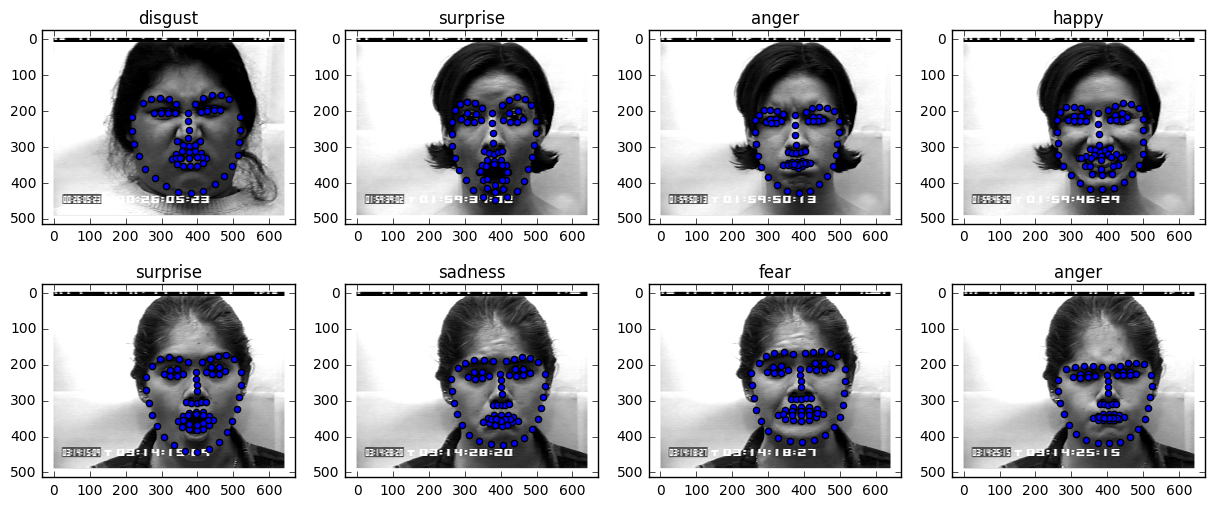

In [5]:
fig = plt.figure(figsize=(15,6))
for i,x in enumerate(df['image'][0:8]):
    if i<8:
        fig.add_subplot(2,4, i+1)
        plt.imshow(x, cmap='gray')
        for j in range(1,69):
            plt.scatter(df["lx"+str(j)][i], df["ly"+str(j)][i])
        plt.title(emotions[df.loc[i,'emotion']])

# Classification Model (Approach 1)

Since we have the dataset reformatted with proper landmarks coordinates and emotion classes, a simple approach could be done by using a SVM classifier considering the raw coordinates independently. For that, Sklearn library was used with 80/20 split of train/test data:

### Linear SVM

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(df.iloc[:, 3:], df["emotion"], test_size=0.20, random_state=42)
simple_clf = SVC(kernel='linear', probability=True, tol=1e-3)
simple_clf.fit(X_train, Y_train)
print("Accuracy Test: " + str(metrics.accuracy_score(Y_test, simple_clf.predict(X_test))))

Accuracy Test: 0.787878787879


### Grid-Search SVM

Let's use a cross-validation with grid search to find the best parameters just to make sure that we have the best model. Also, we are saving the model into disk for later use.

In [7]:
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['linear', 'rbf'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5, "auto"], 
                     'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100], 'probability': [True, False]}]

clf = GridSearchCV(SVC(), tuned_parameters, cv=5)
clf.fit(X_train, Y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()

Y_pred = clf.predict(X_test)
print("Accuracy: " + str(metrics.accuracy_score(Y_test, Y_pred)))
print()
print(metrics.classification_report(Y_test, Y_pred))

# save the model to disk
filename = 'simple_SVM.sav'
pickle.dump(clf, open(filename, 'wb'))

Best parameters set found on development set:

{'probability': True, 'kernel': 'linear', 'gamma': 0.01, 'C': 1}

Accuracy: 0.787878787879

             precision    recall  f1-score   support

          1       0.73      0.80      0.76        10
          2       0.40      0.50      0.44         4
          3       0.93      0.88      0.90        16
          4       0.50      0.33      0.40         3
          5       1.00      0.83      0.91        12
          6       0.78      0.64      0.70        11
          7       0.71      1.00      0.83        10

avg / total       0.80      0.79      0.79        66



# Classification Model (Approach 2)

In this approach was used the Geometric Spatial Model of Emotions with some features extracted based on center of gravity and distance of all landmarks points based on it. The ideia was based on tutorial: http://www.paulvangent.com/2016/08/05/emotion-recognition-using-facial-landmarks/ . Having more features correlating points, the DataFrame will contains more correlated features and the classification model could improve of that.

## Feature generation

Before talking about classification, the feature generation was done based on the function below that takes a Pandas Dataframe and returns some metrics such as:
- Mean of all x landmark points for each sample
- Mean of all y landmark points for each sample
- Distance between each landmark point and the center of gravity
- Difference between each x landmark point and x mean
- Difference between each y landmark point and y mean
- Angle related to each landmark point and the center of gravity

In [8]:
def extract_features(dataframe):
    mean_x_list, mean_y_list, xcentral_list, ycentral_list, dist_list, angle_list= [], [], [], [], [], []
    for i in range(dataframe.shape[0]):
        x_list, y_list, xcentral, ycentral, dist, angle = [], [], [], [], [], []
        for e in dataframe.iloc[i, ::2]:
            x_list.append(float(e))
        for e in dataframe.iloc[i, 1::2]:
            y_list.append(float(e))

        xmean = np.mean(x_list)
        ymean = np.mean(y_list)

        for x, y in zip(x_list, y_list):
            xcentral.append(x - xmean)
            ycentral.append(y - ymean)
            meannp = np.asarray((ymean,xmean))
            coornp = np.asarray((y,x))
            dist.append(np.linalg.norm(coornp-meannp))
        
        for x, y in zip(xcentral, ycentral):
            angle.append(int(math.atan((y-ymean)/(x-xmean))*360/math.pi))
            
            
        xcentral_list.append(xcentral)
        ycentral_list.append(ycentral)
        dist_list.append(dist)
        angle_list.append(angle)
        mean_x_list.append(xmean)
        mean_y_list.append(ymean)
        
    return mean_x_list, mean_y_list, xcentral_list, ycentral_list, dist_list, angle_list

After extract some features from landmark points, the code below takes care of adding them to Dataframe with proper index names to better understanding. The transformed Dataframe is also showed with the shapes of each extra feature generated.

In [9]:
df_full = df.iloc[:, 3:]
mean_x_list, mean_y_list, xcentral_list, ycentral_list, dist_list, angle_list = extract_features(df_full)
df_full["x_mean"], df_full["y_mean"], df_full["x_central"], df_full["y_central"] , df_full["dist"], df_full["angle"] = mean_x_list, mean_y_list, xcentral_list, ycentral_list, dist_list, angle_list

central_x_names = ["central_x_"+str(index) for index in df_full['x_central'].apply(pd.Series).columns.values]
central_y_names = ["central_y_"+str(index) for index in df_full['y_central'].apply(pd.Series).columns.values]
dist_names = ["dist_"+str(index) for index in df_full['dist'].apply(pd.Series).columns.values]
angle_names = ["angle_"+str(index) for index in df_full['angle'].apply(pd.Series).columns.values]
central_x_df = pd.DataFrame(df_full["x_central"].values.tolist(), columns=central_x_names)
central_y_df = pd.DataFrame(df_full["y_central"].values.tolist(), columns=central_y_names)
dist_df = pd.DataFrame(df_full["dist"].values.tolist(), columns=dist_names)
angle_df = pd.DataFrame(df_full["angle"].values.tolist(), columns=angle_names)

df_full.drop("x_central", 1, inplace=True)
df_full.drop("y_central", 1, inplace= True)
df_full.drop("dist", 1, inplace= True)
df_full.drop("angle", 1, inplace= True)

df_full.reset_index(drop=True, inplace=True)
central_x_df.reset_index(drop=True, inplace=True)
central_y_df.reset_index(drop=True, inplace=True)
dist_df.reset_index(drop=True, inplace=True)
angle_df.reset_index(drop=True, inplace=True)

df_full = pd.concat([df_full, central_x_df, central_y_df, dist_df, angle_df], axis=1)
print("Dataframe full shape = " + str(df_full.shape))
print("Dataframe central_x shape = " + str(central_x_df.shape))
print("Dataframe central_y shape = " + str(central_y_df.shape))
print("Dataframe dist shape = " + str(dist_df.shape))
print("Dataframe angle shape = " + str(angle_df.shape))
df_full.head()

Dataframe full shape = (327, 410)
Dataframe central_x shape = (327, 68)
Dataframe central_y shape = (327, 68)
Dataframe dist shape = (327, 68)
Dataframe angle shape = (327, 68)


,lx1,ly1,lx2,ly2,lx3,ly3,lx4,ly4,lx5,ly5,...,angle_58,angle_59,angle_60,angle_61,angle_62,angle_63,angle_64,angle_65,angle_66,angle_67
0,217.79271,217.08805,216.88443,254.86448,223.55064,291.71873,238.07867,326.44699,254.73368,360.31063,...,55,53,57,59,61,66,67,66,61,59
1,263.46593,230.32290,263.25706,264.65208,264.66220,298.43859,271.52795,331.84044,284.62917,363.38441,...,49,53,58,63,67,69,67,60,54,55
2,262.26276,225.81926,262.81201,259.27966,265.15302,292.26124,272.00745,324.97705,281.51414,356.86743,...,62,61,63,64,64,66,68,66,64,64
3,260.08531,223.90821,260.49059,257.21083,261.66175,290.18621,264.24104,323.24917,276.21509,353.92007,...,53,55,58,62,65,70,74,65,59,57
4,255.62132,235.24729,257.83829,270.79358,264.55701,305.36926,274.38013,339.32645,287.58229,371.97415,...,54,53,57,61,65,67,66,62,59,57


### Grid-Search SVM

This model is based on finding the best parameters using GridSearch and also avoid overfitting using cross-validation. SVM will be again the choice of classifier due to it's good optimization, fast trainning for large number of features and reduced number of samples.

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(df_full, df["emotion"], test_size=0.20, random_state=42)

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['linear', 'rbf'], 'gamma': [1e-2, 1e-3, "auto"], 
                     'C': [1, 5, 10, 100], 'probability': [True, False]}]

clf = GridSearchCV(SVC(), tuned_parameters, cv=5)
clf.fit(X_train, Y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()

Y_pred = clf.predict(X_test)
print("Accuracy: " + str(metrics.accuracy_score(Y_test, Y_pred)))
print()
print(metrics.classification_report(Y_test, Y_pred))

# save the model to disk
filename = 'gridsearch_SVM.sav'
pickle.dump(clf, open(filename, 'wb'))

Best parameters set found on development set:

{'probability': True, 'kernel': 'linear', 'gamma': 0.01, 'C': 1}

Accuracy: 0.848484848485

             precision    recall  f1-score   support

          1       0.80      0.80      0.80        10
          2       0.60      0.75      0.67         4
          3       0.93      0.88      0.90        16
          4       1.00      0.67      0.80         3
          5       1.00      0.83      0.91        12
          6       0.82      0.82      0.82        11
          7       0.77      1.00      0.87        10

avg / total       0.86      0.85      0.85        66



The feature generation helped to increase the accuracy of the model in this case and the GridSearch cross-validation model could keep the generalization without overfitting the classifier.

# Classification Model (Approach 3) - Deep Learning

In this approach we will use a transfer learning method since we already have trained a model using the FER2013 dataset. So, we will just load this model and try to predict based on a different dataset.

### Emotion Label transformation

In order to make the prediction we need to fit the emotion labels to match the deep learning model trained on FER2013 data. So, we transformed the number labels and then we created the one hot encoding.

In [11]:
# Actual layout
# 0=neutral, 1=anger, 2=contempt, 3=disgust, 4=fear, 5=happy, 6=sadness, 7=surprise
# mapping to the same as FER
# 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
#df = df[df.emotion != 2] # deleting contempt
#df = df.reset_index(drop=True)
df["emotion"].replace({1:0, 3:1, 4:2, 5:3, 6:4, 7:5, 2:6}, inplace=True)
df.head()

,filename,emotion,image,lx1,ly1,lx2,ly2,lx3,ly3,lx4,...,lx64,ly64,lx65,ly65,lx66,ly66,lx67,ly67,lx68,ly68
0,landmarks\S005\001\S005_001_00000011_landmarks...,1,"[[0, 35, 99, 151, 193, 235, 255, 249, 208, 170...",217.79271,217.08805,216.88443,254.86448,223.55064,291.71873,238.07867,...,399.97572,327.51749,411.74155,327.77521,399.62511,328.03292,376.15740,331.74992,352.81773,330.70822
1,landmarks\S010\002\S010_002_00000014_landmarks...,5,"[[2, 24, 82, 131, 158, 208, 252, 252, 219, 173...",263.46593,230.32290,263.25706,264.65208,264.66220,298.43859,271.52795,...,403.58855,350.40814,416.57084,369.70181,404.82021,392.83535,384.13530,405.86390,360.81365,390.53949
2,landmarks\S010\004\S010_004_00000019_landmarks...,0,"[[0, 25, 84, 138, 177, 228, 255, 243, 201, 156...",262.26276,225.81926,262.81201,259.27966,265.15302,292.26124,272.00745,...,390.23933,345.92457,399.16209,345.88359,390.19353,346.44445,381.75882,349.40795,373.46253,347.09218
3,landmarks\S010\006\S010_006_00000015_landmarks...,3,"[[0, 37, 91, 148, 203, 242, 255, 255, 211, 168...",260.08531,223.90821,260.49059,257.21083,261.66175,290.18621,264.24104,...,409.57456,327.30775,437.23522,329.58437,414.71252,353.25834,383.23087,360.30295,351.31282,354.16516
4,landmarks\S011\001\S011_001_00000016_landmarks...,5,"[[0, 7, 64, 124, 151, 196, 246, 255, 222, 177,...",255.62132,235.24729,257.83829,270.79358,264.55701,305.36926,274.38013,...,416.03879,341.00597,428.73874,353.30120,415.51707,362.42730,397.97747,367.79251,375.83861,364.73401


In [12]:
from keras.utils import np_utils
def one_hot(Y_test):
    y_test_oh = np_utils.to_categorical(Y_test)
    print (y_test_oh.shape)
    return y_test_oh
y_test_oh = one_hot(df['emotion'])

(327, 7)


### Image feature transformation

As the size of the images are different comparing CK+ and FER2013, a image resize is needed as well as a crop on each face since the CK+ dataset contains people a little bit far from the camera.

For simplification, we used OpenCV Haarcascade to crop the images before reshape them to (48,48).

(327, 1, 48, 48)

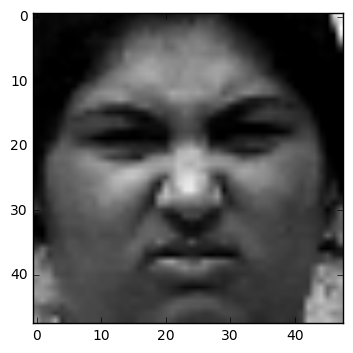

In [13]:
n_samples = df['image'].shape[0]
images = np.zeros((n_samples, 48, 48))

for i in range(n_samples):
    haar_face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')
    face = haar_face_cascade.detectMultiScale(df["image"][i], scaleFactor=1.1, minNeighbors=5);
    (x,y,w,h) = face[0]
    crop_img = df["image"][i][y: y+h, x: x+w]
    image = cv2.resize(crop_img, (48, 48), interpolation = cv2.INTER_CUBIC)
    images[i] = image.reshape(48, 48)

plt.imshow(images[0], cmap='gray')
images = images.reshape(n_samples,-1)
images /=255.
#reshape to default format(n_samples,channel,w,h)
images = images.reshape((n_samples,1,48,48))
images.shape

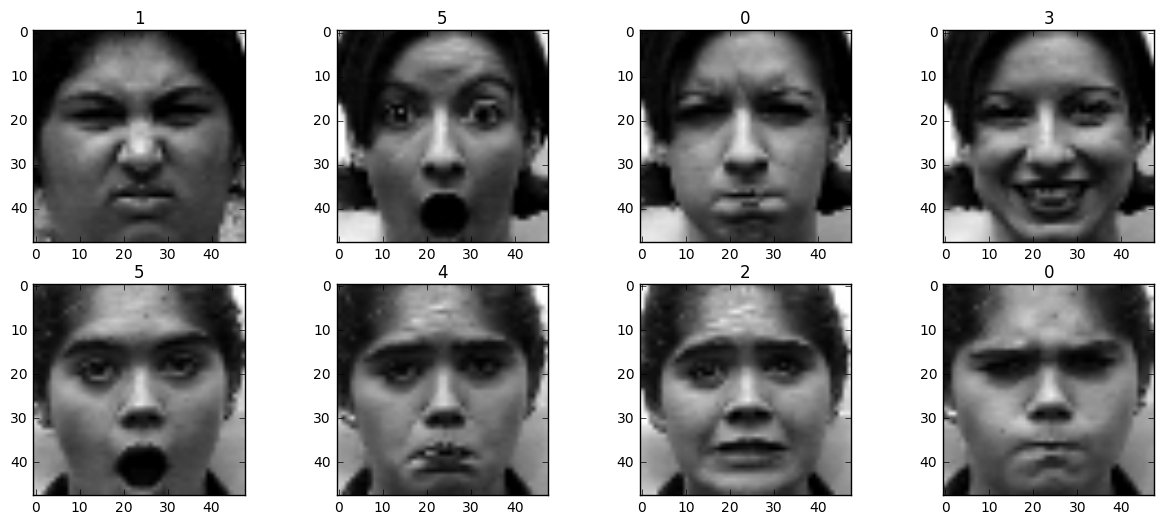

In [14]:
# 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
fig = plt.figure(figsize=(15,6))
for i,x in enumerate(images):
    if i<8:
        fig.add_subplot(2,4, i+1)
        plt.imshow(x.reshape(48,48), cmap='gray')
        plt.title(df["emotion"][i])

### Loading Deep Learning Model

In [15]:
def model_build(nb_classes = 7):
    img_rows, img_cols = 48, 48 # Dimensões das imagens
    input_shape = (1, img_rows, img_cols)

    # Definindo a rede
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(32,(3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(32,(3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Dropout(0.5))

    # Aqui os features deixam de ser imagens
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))
    return model

model = model_build()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 46, 46)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 46, 46)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 23, 23)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 21, 21)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 21, 21)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 10, 10)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 8, 8)          9248      
__________

In [16]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
model.load_weights("weights28709.best.hdf5")

In [18]:
loss, accuracy = model.evaluate(images, y_test_oh, batch_size=128, verbose=1)
print("\n[INFO] accuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))

327/327 [==============================] - 2s     

[INFO] accuracy on the test data set: 53.21% [1.23578]


The evalution of CK+ using FER2013 Deep Learning Model showed that a simple transfer learning in this case is not sufficient to predict with a good accuracy. This fact could be related that FER2013 dataset is so different than CK+ because of the images sizes and head pose variations. A good approach could be making a fine-tuning to better adapt the pre-trained model to the new images.

# Real-time Landmarks detection

In order to make sure the classifier could predict well the emotions, we chose the best model for CK+ (SVM based on landmarks) and we made a real-time detection.

The below code show some preprocessing taking camera frame, extracting landmarks using DLib and predicting after loading the model trained.

In [23]:
#Import required modules
import cv2
import dlib
import time
import pandas as pd
import pickle

#Set up some required objects
video_capture = cv2.VideoCapture(0) #Webcam object
detector = dlib.get_frontal_face_detector() #Face detector
#Landmark identifier.
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat") 

while True:
        
    ret, frame = video_capture.read()
           
    #Sometimes, cap may not have initialized the capture.
    #In that case, this code shows error. You can check whether it is initialized or not by the method cap.isOpened().
    #If it is True, OK. Otherwise open it using cap.open().
    if not video_capture.isOpened():
        video_capture.open()
    
    #video_capture.read() returns a bool (True/False).
    #If frame is read correctly, it will be True. So you can check end of the video by checking this return value.
    if not ret:
        break 
        
    #Waiting input key from the user
    k = cv2.waitKey(1)
    
    if k%256 == 27: # ESC pressed
        break
    else:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        clahe_image = clahe.apply(gray)

        # building indexes for each feature and label
        columns = []
        for i in range(1, 69):
            columns.append("lx"+str(i))
            columns.append("ly"+str(i))
        df_test = pd.DataFrame(columns = columns)
        
        detections = detector(clahe_image, 1)#Detect the faces in the image
        for k,d in enumerate(detections): #For each detected face
            shape = predictor(clahe_image, d) #Get coordinates
            
            current_row = []
            for i in range(0,68): #There are 68 landmark points on each face
                current_row.append(shape.part(i).x)
                current_row.append(shape.part(i).y)
                #For each point, draw a red circle with thickness2 on the original frame
                cv2.circle(frame, (shape.part(i).x, shape.part(i).y), 1, (0,0,255), thickness=2)
            
            df_test.loc[0] = current_row
            # load the model from disk
            svm = pickle.load(open('simple_SVM.sav', 'rb'))
            result = svm.predict(df_test)

            haar_face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')
            faces = haar_face_cascade.detectMultiScale(clahe_image, scaleFactor=1.1, minNeighbors=5);
            if (len(faces))!=0:        
                (x,y,w,h) = faces[0]
            else:
                x=y=w=h=10
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(frame,str(emotions[result]), (x+ int(w/3),y-5),font,0.55,(0,255,0),1) #Draw the text
        cv2.imshow("image", frame) #Display the frame

# When everything done, release the capture
video_capture.release()
cv2.destroyAllWindows()

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:69: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
